# Fintech smart advisor
For this notebook, we will develop a smart advisor to predict the credit of custors.

In [1]:

import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation

## finance knowledge about credit
1. Credit Underwriting
In commercial banking, underwriting means assessing the credit worthiness of borrowers and agreeing to fund loans. The risk is that the borrower will default on the loan and thus fail to repay the amount borrowed. The fee for underwriting this risk is typically periodic interest charged to the borrower as long as there is a balance due on the loan. 简言之，银行考察你的信用情况，然后决定贷不贷款，带给你多少。

2. First Payment Default
you don't make the first payment on time. the repercussions can be especially harsh.第一次还款就没按时。
3.  Information Leakage
Information Leakage is an application weakness where an application reveals sensitive data, such as technical details of the web application, environment, or user-specific data. Sensitive data may be used by an attacker to exploit the target web application, its hosting network, or its users. 系统的漏洞导致敏感信息泄漏
4. Feedback Loop
A feedback loop is system structure that causes output from one node to eventually influence input to that same node.
反馈回路
5. Lift Chart
A lift chart graphically represents the improvement that a mining model provides when compared against a random guess, and measures the change in terms of a lift score. By comparing the lift scores for different models, you can determine which model is best. Lift is simply the ratio of these values: target response divided by average response. 
提升表，以一个反应做基准，用别的反应除以这个反应。score越高，说明模型运行越好。

## general question?
#### 1. 数据集中哪个（哪几个）变量可以作为surpvised predictive modeling的target/label？
1.  target: loan_status , 不用int_rate or sub_grade，是因为这个是lending club给出的基准模型，我们的模型要基于这个模型，如果使用同样的，只能跟他们一样




## Load data

In [2]:
# Load Data

print("# Load Loan Data, year 2014")
df1 = pd.read_csv("LoanStats3c.csv", skiprows=1)
print ("Data Loaded.")
print("# Load Loan Data, year 2015")
df2 = pd.read_csv("LoanStats3d.csv", skiprows=1)
print ("Data Loaded.")


# Load Loan Data, year 2014


/Users/bowenzhi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data Loaded.
# Load Loan Data, year 2015
Data Loaded.


/Users/bowenzhi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
!head -n 2 LoanStats3c.csv

Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_joint","dti_joint","verification_status_joint","acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_il_6m","ope

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(86), object(25)
memory usage: 199.5+ MB


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [6]:
df1.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,36805548,39558264.0,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0
1,38098114,40860827.0,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0
2,37842129,40605224.0,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,...,0.0,2.0,91.4,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0
3,37612354,40375473.0,12800.0,12800.0,12800.0,60 months,17.14%,319.08,D,D4,...,0.0,0.0,76.9,100.0,0.0,0.0,368700.0,18007.0,4400.0,18000.0
4,37662224,40425321.0,7650.0,7650.0,7650.0,36 months,13.66%,260.20,C,C3,...,0.0,2.0,100.0,100.0,0.0,0.0,82331.0,64426.0,4900.0,64031.0


In [7]:
df2.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68446746,73336569.0,12000.0,12000.0,12000.0,36 months,5.32%,361.38,A,A1,...,0.0,1.0,94.7,0.0,0.0,0.0,183062.0,11146.0,8500.0,29053.0
1,68338832,73542831.0,1400.0,1400.0,1400.0,36 months,12.88%,47.10,C,C2,...,0.0,1.0,100.0,75.0,0.0,0.0,372109.0,75258.0,34500.0,55501.0
2,68341763,72928789.0,20000.0,20000.0,20000.0,60 months,10.78%,432.66,B,B4,...,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,68415473,73305264.0,25000.0,25000.0,25000.0,60 months,13.99%,581.58,C,C4,...,0.0,6.0,100.0,0.0,0.0,0.0,389002.0,89978.0,72600.0,81802.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [8]:
Loan_data = df1.append(df2, ignore_index=True)

In [9]:
Loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656728 entries, 0 to 656727
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 556.2+ MB


#### 2. 为了建立1中的模型，哪部分数据可以用来建模，哪部分不能？请简述理由，并在你准备使用的数据上分出training／testing set
1. 使用其中Fully paid（good loan）和charged off（bad loan）来建模，其他的(on going loan, 有information leakage， loan进行的时间长短，跟default的概率是有关的，离借款期越近，概率越低，时间约长，概率越高）你不能确定是否是好的还是坏的
2. 80/20, 80%的数据用来training，20%用来testing

In [11]:
# catigory of loan_status

Loan_data.loan_status.value_counts()

Current               441196
Fully Paid            148488
Charged Off            43305
Late (31-120 days)     13810
In Grace Period         5954
Late (16-30 days)       3535
Default                  436
Name: loan_status, dtype: int64

In [12]:
Loan_data= Loan_data[(Loan_data.loan_status=='Fully Paid')|(Loan_data.loan_status=='Charged Off')]

In [13]:
Loan_data['loan_status'] = Loan_data.loan_status.map({"Charged Off":1, "Fully Paid":0})

In [14]:
Loan_data['loan_status'].value_counts()

0    148488
1     43305
Name: loan_status, dtype: int64

## Determine out of time testing set and in_time cross_validation set

## Validata Features

In [15]:
# let us examine some features
print Loan_data.emp_title.value_counts().head()
Loan_data.emp_title.unique().shape

Teacher             3224
Manager             3180
Supervisor          1376
Registered Nurse    1369
RN                  1343
Name: emp_title, dtype: int64


(64021,)

In [16]:
Loan_data = Loan_data.drop('all_util',1)
Loan_data = Loan_data.drop('annual_inc_joint',1)
Loan_data = Loan_data.drop('application_type',1)
Loan_data = Loan_data.drop('chargeoff_within_12_mths',1)
Loan_data = Loan_data.drop('collection_recovery_fee',1)
Loan_data = Loan_data.drop('collections_12_mths_ex_med',1)
Loan_data = Loan_data.drop('dti',1)
Loan_data = Loan_data.drop('dti_joint',1)
Loan_data = Loan_data.drop('desc',1)
Loan_data = Loan_data.drop('emp_title',1)
# Loan_data = Loan_data.drop('grade',1)  # attributes about the loan after it was granted
# Loan_data = Loan_data.drop('sub_grade',1) # attributes about the loan after it was granted
Loan_data = Loan_data.drop('id',1)
Loan_data = Loan_data.drop('il_util',1)
Loan_data = Loan_data.drop('inq_fi',1)
Loan_data = Loan_data.drop('inq_last_12m',1)
Loan_data = Loan_data.drop('issue_d',1) # drop this feature because we use 1-9 as training ,and 10-12 as testing, so 
                                        # so for testing, they don't have the feature 1-9
Loan_data = Loan_data.drop('last_pymnt_amnt',1)
Loan_data = Loan_data.drop('last_pymnt_d',1)
Loan_data = Loan_data.drop('last_credit_pull_d',1)
Loan_data = Loan_data.drop('member_id',1)
Loan_data = Loan_data.drop('mo_sin_old_il_acct',1)
Loan_data = Loan_data.drop('mo_sin_old_rev_tl_op',1)
Loan_data = Loan_data.drop('mo_sin_rcnt_rev_tl_op',1)
Loan_data = Loan_data.drop('mo_sin_rcnt_tl',1)
Loan_data = Loan_data.drop('max_bal_bc',1)
Loan_data = Loan_data.drop('mths_since_last_record',1)
Loan_data = Loan_data.drop('mths_since_last_delinq',1)
Loan_data = Loan_data.drop('mths_since_last_major_derog',1)
Loan_data = Loan_data.drop('mths_since_rcnt_il',1)
#Loan_data = Loan_data.drop('mths_since_rcnt_il',1)
Loan_data = Loan_data.drop('mths_since_recent_bc_dlq',1)
Loan_data = Loan_data.drop('mths_since_recent_revol_delinq',1)
Loan_data = Loan_data.drop('next_pymnt_d',1)
Loan_data = Loan_data.drop('num_accts_ever_120_pd',1)
Loan_data = Loan_data.drop('num_tl_120dpd_2m',1)
Loan_data = Loan_data.drop('num_tl_30dpd',1)
Loan_data = Loan_data.drop('num_tl_90g_dpd_24m',1)
Loan_data = Loan_data.drop('open_acc_6m',1)
Loan_data = Loan_data.drop('open_il_6m',1)
Loan_data = Loan_data.drop('open_il_12m',1)
Loan_data = Loan_data.drop('open_il_24m',1)

Loan_data = Loan_data.drop('open_rv_12m',1)
Loan_data = Loan_data.drop('open_rv_24m',1)
Loan_data = Loan_data.drop('out_prncp',1)
Loan_data = Loan_data.drop('out_prncp_inv',1)

Loan_data = Loan_data.drop('policy_code',1)
Loan_data = Loan_data.drop('pymnt_plan',1)
Loan_data = Loan_data.drop('recoveries',1)
Loan_data = Loan_data.drop('revol_bal',1)
Loan_data = Loan_data.drop('tot_coll_amt',1)
#Loan_data = Loan_data.drop('tot_cur_bal',1)
Loan_data = Loan_data.drop('total_bal_il',1)
Loan_data = Loan_data.drop('total_pymnt',1)
Loan_data = Loan_data.drop('total_pymnt_inv',1)
Loan_data = Loan_data.drop('total_rec_int',1)
Loan_data = Loan_data.drop('total_rec_late_fee',1)
Loan_data = Loan_data.drop('total_rec_prncp',1)
Loan_data = Loan_data.drop('total_cu_tl',1)
Loan_data = Loan_data.drop('title',1)
Loan_data = Loan_data.drop('url',1)
#Loan_data = Loan_data.drop('verification_status',1)


In [17]:
Loan_data = Loan_data.drop('verification_status_joint',1)

In [18]:
Loan_data = Loan_data.drop('funded_amnt',1)

In [19]:
Loan_data = Loan_data.drop('funded_amnt_inv',1)

In [20]:
Loan_data = Loan_data.drop('installment',1)

In [21]:
Loan_data = Loan_data.drop('zip_code',1)

In [22]:
Loan_data = Loan_data.drop('initial_list_status',1)

In [23]:
#Loan_data = Loan_data.drop('region',1)

In [24]:
Loan_data.shape

(191793, 48)

## Data cleaning

In [25]:
print Loan_data.columns
print Loan_data.head(1).values
Loan_data.info()

Index([u'loan_amnt', u'term', u'int_rate', u'grade', u'sub_grade',
       u'emp_length', u'home_ownership', u'annual_inc', u'verification_status',
       u'loan_status', u'purpose', u'addr_state', u'delinq_2yrs',
       u'earliest_cr_line', u'inq_last_6mths', u'open_acc', u'pub_rec',
       u'revol_util', u'total_acc', u'acc_now_delinq', u'tot_cur_bal',
       u'total_rev_hi_lim', u'acc_open_past_24mths', u'avg_cur_bal',
       u'bc_open_to_buy', u'bc_util', u'delinq_amnt', u'mort_acc',
       u'mths_since_recent_bc', u'mths_since_recent_inq', u'num_actv_bc_tl',
       u'num_actv_rev_tl', u'num_bc_sats', u'num_bc_tl', u'num_il_tl',
       u'num_op_rev_tl', u'num_rev_accts', u'num_rev_tl_bal_gt_0', u'num_sats',
       u'num_tl_op_past_12m', u'pct_tl_nvr_dlq', u'percent_bc_gt_75',
       u'pub_rec_bankruptcies', u'tax_liens', u'tot_hi_cred_lim',
       u'total_bal_ex_mort', u'total_bc_limit', u'total_il_high_credit_limit'],
      dtype='object')
[[15000.0 ' 60 months' ' 12.39%' 'C' 'C1' 

In [26]:
Loan_data.replace('n/a',np.nan,inplace=True)

In [27]:
Loan_data.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
grade                             0
sub_grade                         0
emp_length                     9362
home_ownership                    0
annual_inc                        0
verification_status               0
loan_status                       0
purpose                           0
addr_state                        0
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_util                      110
total_acc                         0
acc_now_delinq                    0
tot_cur_bal                       0
total_rev_hi_lim                  0
acc_open_past_24mths              0
avg_cur_bal                       6
bc_open_to_buy                 2047
bc_util                        2198
delinq_amnt                       0
mort_acc                    

In [301]:
# drop nan and fill it with a random number from avg_cur_bal
average_avg_cur_bal = Loan_data["avg_cur_bal"].mean()
std_age_avg_cur_bal = Loan_data["avg_cur_bal"].std()
count_avg_cur_bal = Loan_data["avg_cur_bal"].isnull().sum()

In [302]:
rand_1 = np.random.randint(average_avg_cur_bal-std_age_avg_cur_bal, average_avg_cur_bal+std_age_avg_cur_bal,
                           size = count_avg_cur_bal)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["avg_cur_bal"][np.isnan(Loan_data["avg_cur_bal"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [303]:
# drop nan and fill it with a random number from bc_open_to_buy
average_bc_open_to_buy = Loan_data["bc_open_to_buy"].mean()
std_age_bc_open_to_buy = Loan_data["bc_open_to_buy"].std()
count_bc_open_to_buy = Loan_data["bc_open_to_buy"].isnull().sum()

In [304]:
rand_1 = np.random.randint(average_bc_open_to_buy-std_age_bc_open_to_buy, average_bc_open_to_buy+std_age_bc_open_to_buy,
                           size = count_bc_open_to_buy)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["bc_open_to_buy"][np.isnan(Loan_data["bc_open_to_buy"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [305]:
# drop nan and fill it with a random number from bc_util
average_bc_util = Loan_data["bc_util"].mean()
std_bc_util = Loan_data["bc_util"].std()
count_bc_util = Loan_data["bc_util"].isnull().sum()

In [306]:
count_bc_util

2198

In [307]:
Loan_data.bc_util.describe()

count    189595.000000
mean         61.062952
std          28.066651
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max         255.200000
Name: bc_util, dtype: float64

In [308]:
rand_1 = np.random.randint(average_bc_util-std_bc_util, average_bc_util+std_bc_util,size = count_bc_util)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["bc_util"][np.isnan(Loan_data["bc_util"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(array([  2.58780000e+04,   4.24780000e+04,   5.43820000e+04,
          6.79070000e+04,   1.09800000e+03,   3.40000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          3.00000000e+00]),
 array([   0.  ,   25.52,   51.04,   76.56,  102.08,  127.6 ,  153.12,
         178.64,  204.16,  229.68,  255.2 ]),
 <a list of 10 Patch objects>)

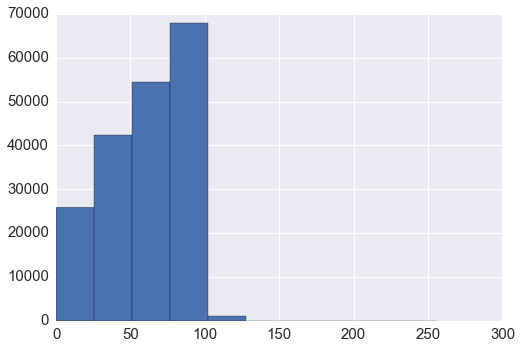

In [309]:
plt.hist(Loan_data.bc_util)

In [310]:
# drop nan and fill it with a random number from mths_since_recent_bc
average_mths_since_recent_bc = Loan_data["mths_since_recent_bc"].mean()
std_mths_since_recent_bc = Loan_data["mths_since_recent_bc"].std()
count_mths_since_recent_bc = Loan_data["mths_since_recent_bc"].isnull().sum()

In [311]:
rand_1 = np.random.randint(average_mths_since_recent_bc-std_mths_since_recent_bc,average_mths_since_recent_bc+std_mths_since_recent_bc,  
                           size = count_mths_since_recent_bc)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["mths_since_recent_bc"][np.isnan(Loan_data["mths_since_recent_bc"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(array([  1.65070000e+05,   1.95330000e+04,   5.53000000e+03,
          1.12300000e+03,   2.91000000e+02,   1.06000000e+02,
          8.30000000e+01,   3.30000000e+01,   1.50000000e+01,
          9.00000000e+00]),
 array([  -6. ,   41.9,   89.8,  137.7,  185.6,  233.5,  281.4,  329.3,
         377.2,  425.1,  473. ]),
 <a list of 10 Patch objects>)

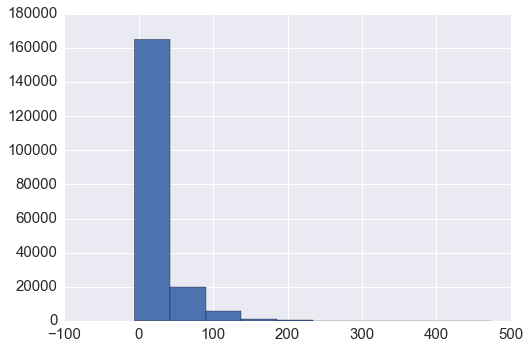

In [312]:
plt.hist(Loan_data.mths_since_recent_bc)

In [313]:
# drop nan and fill it with a random number from percent_bc_gt_75
average_percent_bc_gt_75 = Loan_data["percent_bc_gt_75"].mean()
std_percent_bc_gt_75 = Loan_data["percent_bc_gt_75"].std()
count_percent_bc_gt_75 = Loan_data["percent_bc_gt_75"].isnull().sum()

In [314]:
rand_1 = np.random.randint(average_percent_bc_gt_75-std_percent_bc_gt_75, average_percent_bc_gt_75+std_percent_bc_gt_75,
                           size = count_percent_bc_gt_75)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["percent_bc_gt_75"][np.isnan(Loan_data["percent_bc_gt_75"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [315]:
# drop nan and fill it with a random number from mths_since_recent_inq
average_mths_since_recent_inq = Loan_data["mths_since_recent_inq"].mean()
std_mths_since_recent_inq = Loan_data["mths_since_recent_inq"].std()
count_mths_since_recent_inq = Loan_data["mths_since_recent_inq"].isnull().sum()

In [316]:
rand_1 = np.random.randint(average_mths_since_recent_inq-std_mths_since_recent_inq, average_mths_since_recent_inq+std_mths_since_recent_inq,
                           size = count_mths_since_recent_inq)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["mths_since_recent_inq"][np.isnan(Loan_data["mths_since_recent_inq"])] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [317]:
Loan_data["mths_since_recent_inq"].describe()

count    191793.000000
mean          6.236682
std           5.562557
min           0.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          25.000000
Name: mths_since_recent_inq, dtype: float64

In [318]:
Loan_data.revol_util.fillna(value=0,inplace=True)

In [319]:
Loan_data.isnull().sum()

loan_amnt                        0
term                             0
int_rate                         0
grade                            0
sub_grade                        0
emp_length                    9362
home_ownership                   0
annual_inc                       0
verification_status              0
loan_status                      0
purpose                          0
addr_state                       0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_util                       0
total_acc                        0
acc_now_delinq                   0
tot_cur_bal                      0
total_rev_hi_lim                 0
acc_open_past_24mths             0
avg_cur_bal                      0
bc_open_to_buy                   0
bc_util                          0
delinq_amnt                      0
mort_acc                         0
mths_since_recent_bc

In [320]:
# process int_rate
Loan_data.int_rate = pd.Series(Loan_data.int_rate).str.replace('%','').astype(float)

In [321]:
# process emp_length
Loan_data['emp_length'].replace(to_replace='[^0-9]+',value='',inplace=True,regex=True)
Loan_data.emp_length.fillna(value=0,inplace=True)
Loan_data['emp_length'] = Loan_data['emp_length'].astype(int)

In [322]:
average_emp_length = Loan_data["emp_length"].mean()
std_emp_length = Loan_data["emp_length"].std()
count_emp_length = len(Loan_data["emp_length"][Loan_data.emp_length==0])

In [323]:
count_emp_length

9362

In [324]:
rand_1 = np.random.randint(average_emp_length-std_emp_length, average_emp_length+std_emp_length,
                           size = count_emp_length)

# fill NaN values in avg_cur_bal column with random values generated
Loan_data["emp_length"][Loan_data.emp_length == 0] = rand_1

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [325]:
Loan_data['emp_length'].describe()

count    191793.000000
mean          6.038197
std           3.500095
min           1.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: emp_length, dtype: float64

In [326]:
from datetime import datetime
Loan_data.earliest_cr_line = pd.to_datetime(Loan_data.earliest_cr_line)

In [327]:
dttoday = datetime.now().strftime('%Y-%m-%d')
Loan_data.earliest_cr_line = Loan_data.earliest_cr_line.apply(lambda x: (
        np.timedelta64((x-pd.Timestamp(dttoday)),'D').astype(int))/-365)

In [328]:
Loan_data.revol_util = pd.Series(Loan_data.revol_util).str.replace('%','').astype(float)

In [329]:
Loan_data.revol_util.describe()

count    191683.000000
mean         52.435214
std          24.164263
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max         892.300000
Name: revol_util, dtype: float64

In [330]:
Loan_data.revol_util.fillna(value=0,inplace=True)

In [331]:
Loan_data.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
addr_state                    0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
acc_now_delinq                0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
delinq_amnt                   0
mort_acc                      0
mths_since_recent_bc          0
mths_since_recent_inq         0
num_actv_bc_tl                0
num_actv

## Detailed EDA

In [187]:
print Loan_data.columns
print Loan_data.head(1).values
Loan_data.info()

Index([u'loan_amnt', u'term', u'int_rate', u'grade', u'sub_grade',
       u'emp_length', u'home_ownership', u'annual_inc', u'verification_status',
       u'loan_status', u'purpose', u'addr_state', u'delinq_2yrs',
       u'earliest_cr_line', u'inq_last_6mths', u'open_acc', u'pub_rec',
       u'revol_bal', u'revol_util', u'total_acc', u'acc_now_delinq',
       u'tot_cur_bal', u'total_rev_hi_lim', u'acc_open_past_24mths',
       u'avg_cur_bal', u'bc_open_to_buy', u'bc_util', u'delinq_amnt',
       u'mort_acc', u'mths_since_recent_bc', u'mths_since_recent_inq',
       u'num_actv_bc_tl', u'num_actv_rev_tl', u'num_bc_sats', u'num_bc_tl',
       u'num_il_tl', u'num_op_rev_tl', u'num_rev_accts',
       u'num_rev_tl_bal_gt_0', u'num_sats', u'num_tl_op_past_12m',
       u'pct_tl_nvr_dlq', u'percent_bc_gt_75', u'pub_rec_bankruptcies',
       u'tax_liens', u'tot_hi_cred_lim', u'total_bal_ex_mort',
       u'total_bc_limit', u'total_il_high_credit_limit'],
      dtype='object')
[[15000.0 ' 60 months

In [33]:
sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5})

In [360]:
Loan_data.columns.values

array(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'acc_now_delinq', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'train_flag'], dtype=object)

In [41]:
# process continuous variable
def continuous_var_plot(feature_name):
    sns.set_style("whitegrid", {'axes.edgecolor': '0'})
    factor = pd.qcut(Loan_data[feature_name],5,labels = False) # group the data 
    table = Loan_data.groupby([factor, 'loan_status']).size() #get group size counts, hashed by the two variables
    table = table.unstack('loan_status')
    normedtable = table.div(table.sum(1),axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    normedtable.ix[:,1].plot(kind='bar', alpha=0.9, color='blue', ax=ax)
    ax.set_xlabel("%s percentile" % feature_name, fontsize=20)
    ax.set_ylabel('Default Rate', fontsize=20)
    x = range(5)
    labels = ['20%tile', '40%tile','60%tile','80%tile','100%tile']
    plt.xticks(x, labels, rotation='0', fontsize=18)
    sns.despine()
    ax.set_title("Loan performance with respect to %s" % feature_name)
    

In [362]:
# continuous_var_plot('annual_inc')

### loan_amnt

In [69]:
Loan_data.loan_amnt.describe()

count    104512.000000
mean      14418.565332
std        8338.861475
min        1000.000000
25%        8000.000000
50%       12175.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

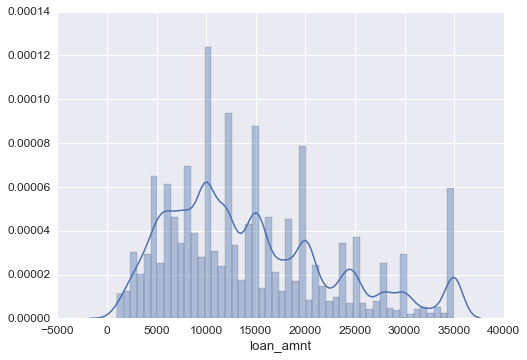

In [71]:
sns.distplot(Loan_data.loan_amnt)

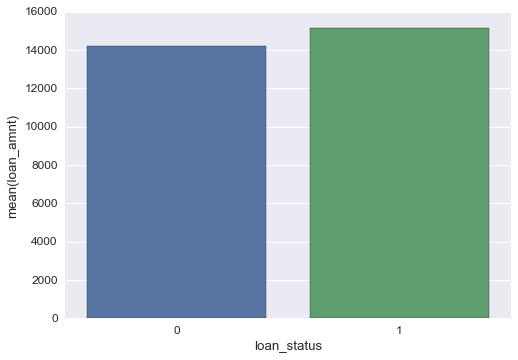

In [73]:
# average of loan_amnt for each loan(charged off, fully paid)
loan_amnt_status = Loan_data[["loan_amnt", "loan_status"]].groupby(['loan_status'],as_index=False).mean()
sns.barplot(x='loan_status', y='loan_amnt', data=loan_amnt_status)

(array([  7372.,  16535.,  20725.,  15054.,  12888.,  12381.,   5289.,
          5816.,   3143.,   5309.]),
 array([  1000.,   4400.,   7800.,  11200.,  14600.,  18000.,  21400.,
         24800.,  28200.,  31600.,  35000.]),
 <a list of 10 Patch objects>)

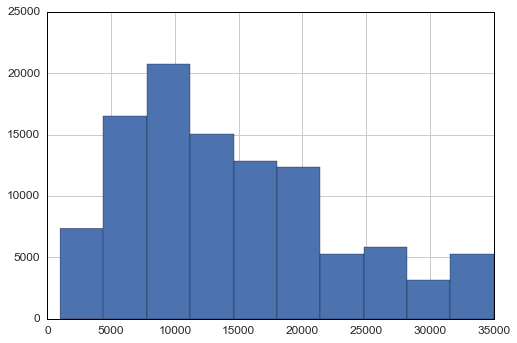

In [78]:
plt.hist(Loan_data.loan_amnt)

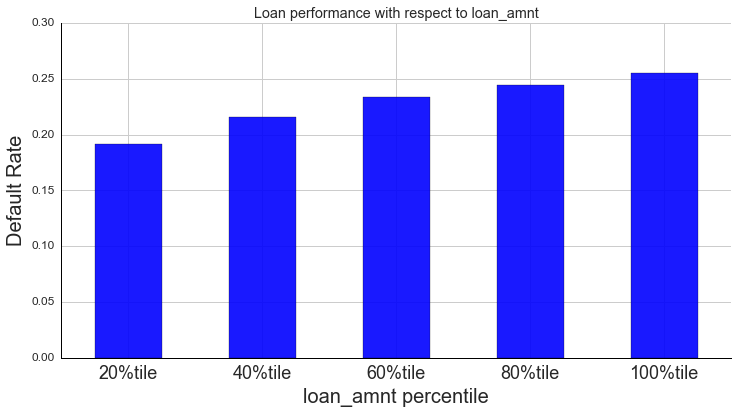

In [79]:
continuous_var_plot('loan_amnt')

### term

In [75]:
Loan_data.term.describe()

count         104512
unique             2
top        36 months
freq           76869
Name: term, dtype: object

In [76]:
Loan_data.term.unique()

array([' 60 months', ' 36 months'], dtype=object)

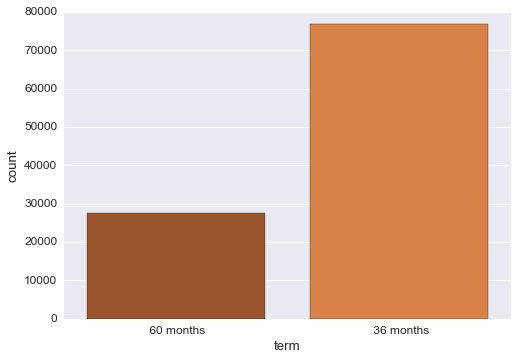

In [77]:
sns.countplot(x="term", data=Loan_data, palette="Oranges_d")

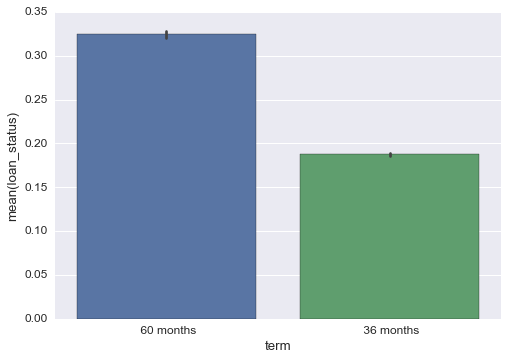

In [34]:
sns.barplot(x='term', y='loan_status', data=Loan_data)

### int_rate

In [36]:
Loan_data.int_rate.describe()

count      191793
unique        147
top        10.99%
freq         8516
Name: int_rate, dtype: object

TypeError: len() of unsized object

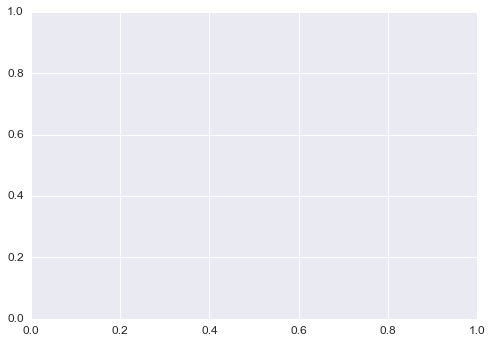

In [37]:
plt.hist(Loan_data.int_rate)

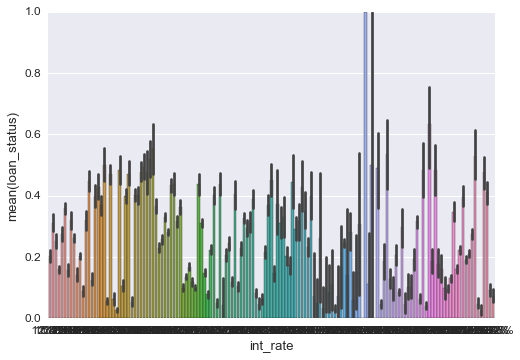

In [38]:
sns.barplot(x='int_rate', y='loan_status', data=Loan_data)
# plt.xticks([0, 5, 10, 15,20,25,30,100])



In [90]:
sns.barplot?


In [40]:
continuous_var_plot('int_rate')

NameError: name 'continuous_var_plot' is not defined

In [81]:
# sns.barplot(x='installment', y='loan_status', data=Loan_data)

### grade

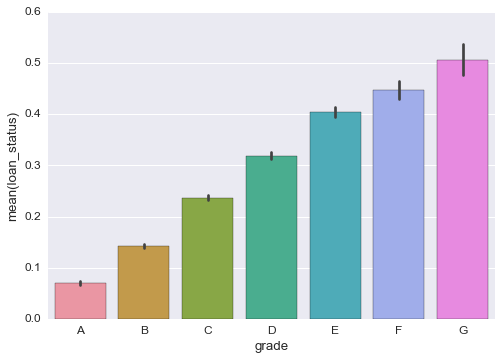

In [82]:
sns.barplot(x='grade', y='loan_status', data=Loan_data, order = ['A','B','C','D','E','F','G'])

### sub_grade

In [83]:
np.sort(Loan_data.sub_grade.unique())

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

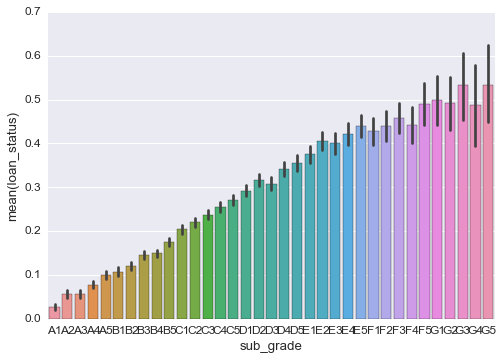

In [84]:
sns.barplot(x='sub_grade', y='loan_status', data=Loan_data, order =np.sort(Loan_data.sub_grade.unique()))

### emp_length

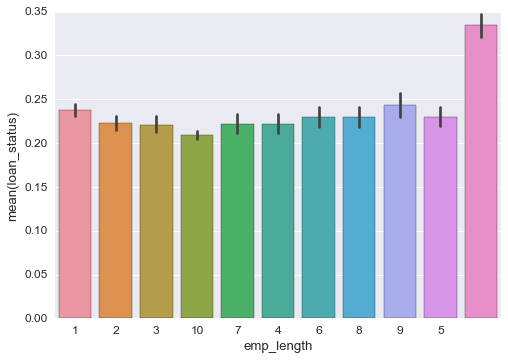

In [85]:
sns.barplot(x='emp_length', y='loan_status', data=Loan_data)

### home_ownership

In [86]:
Loan_data.home_ownership.describe()

count       104512
unique           4
top       MORTGAGE
freq         53192
Name: home_ownership, dtype: object

In [87]:
Loan_data.home_ownership.value_counts()

MORTGAGE    53192
RENT        41460
OWN          9859
ANY             1
Name: home_ownership, dtype: int64

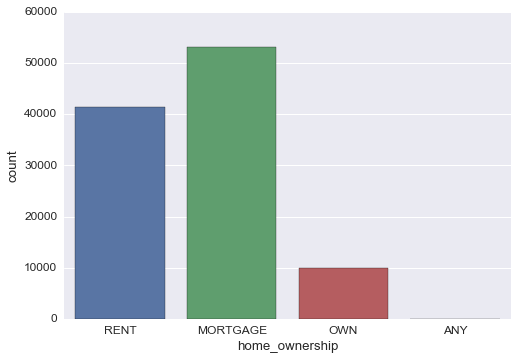

In [88]:
sns.countplot(x='home_ownership', data=Loan_data)

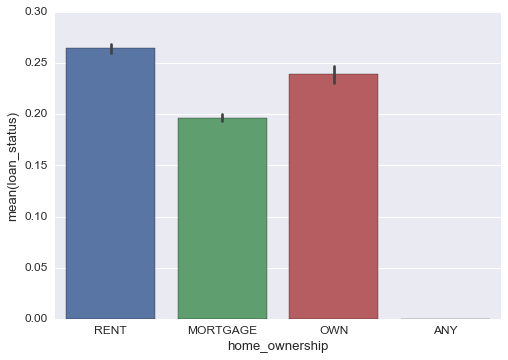

In [89]:
sns.barplot(x='home_ownership', y='loan_status', data=Loan_data)

### annual_inc

In [90]:
Loan_data.annual_inc.describe()

count    1.045120e+05
mean     7.482321e+04
std      5.987171e+04
min      3.000000e+03
25%      4.600000e+04
50%      6.500000e+04
75%      9.000000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

(array([  1.,   3.,  15., ...,   0.,   0.,   1.]),
 array([  3.00000000e+03,   4.86817842e+03,   6.73635684e+03, ...,
          7.49626364e+06,   7.49813182e+06,   7.50000000e+06]),
 <a list of 4013 Patch objects>)

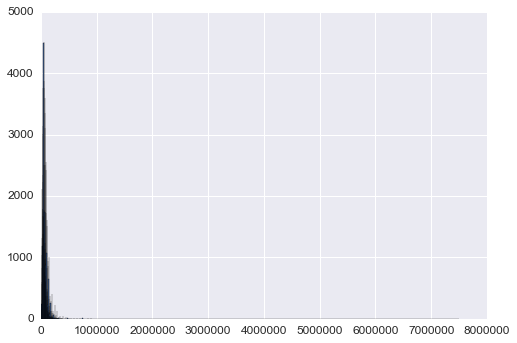

In [91]:
plt.hist(Loan_data.annual_inc, bins='auto')

In [92]:
def get_person(annual_inc):
    if annual_inc > 200000:
        return 'high'
    elif annual_inc < 200000 and annual_inc > 50000:
        return 'mid'
    else:
        return 'low'

In [93]:
Loan_data['annual_inc_dummy'] = Loan_data['annual_inc'].apply(get_person)

In [94]:
Loan_data.annual_inc_dummy.describe()

count     104512
unique         3
top          mid
freq       68888
Name: annual_inc_dummy, dtype: object

In [95]:
Loan_data.annual_inc_dummy.value_counts()

mid     68888
low     33783
high     1841
Name: annual_inc_dummy, dtype: int64

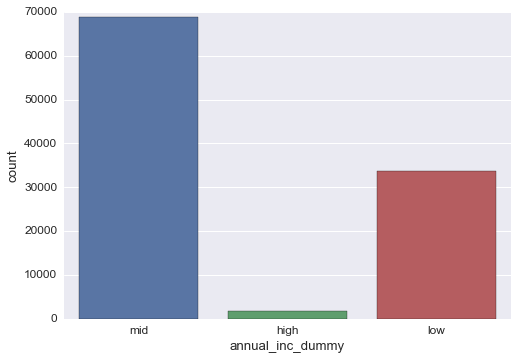

In [96]:
sns.countplot(x='annual_inc_dummy',  data=Loan_data)

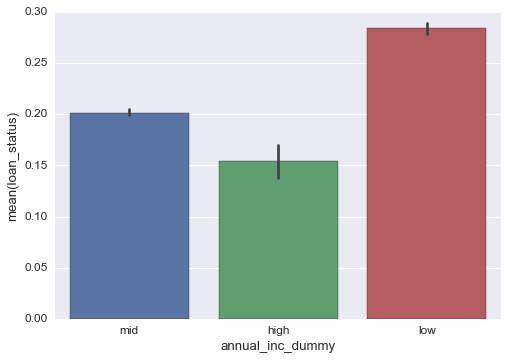

In [97]:
sns.barplot(x='annual_inc_dummy', y='loan_status', data=Loan_data)

### purpose

In [98]:
len(Loan_data.purpose.unique())

13

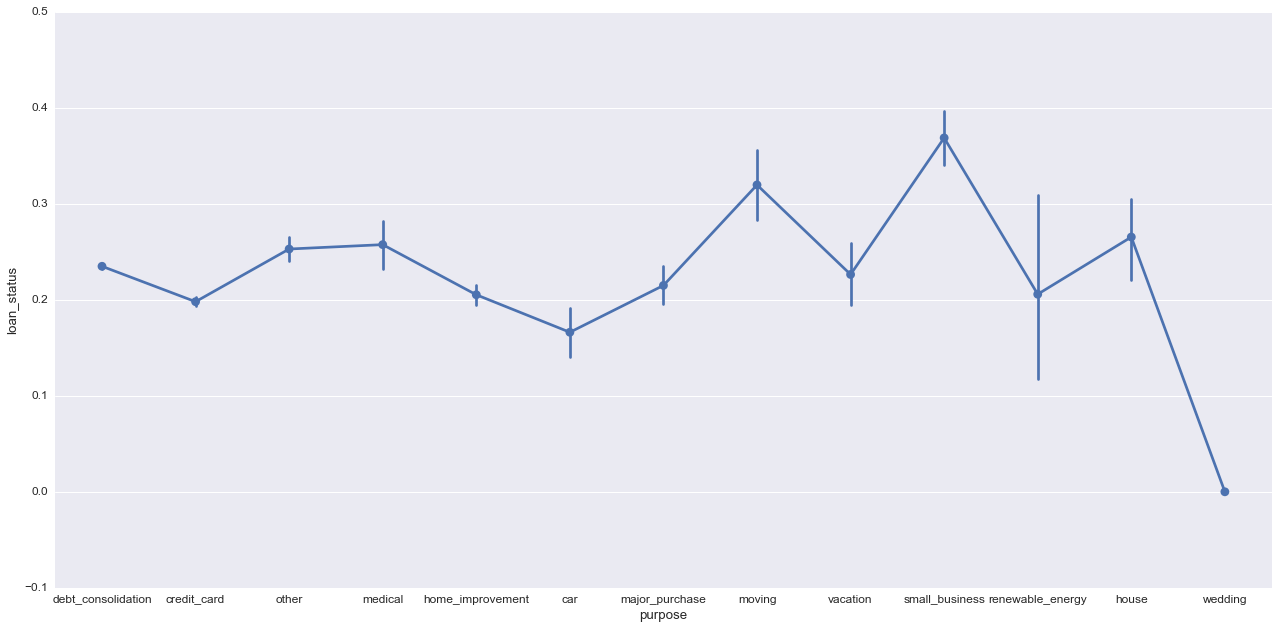

In [99]:
sns.factorplot(x='purpose', y='loan_status', data=Loan_data, size=9,aspect=2)

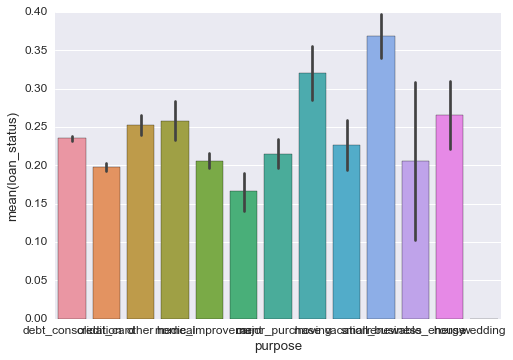

In [100]:
sns.barplot(x='purpose', y='loan_status', data=Loan_data)

### addr_state

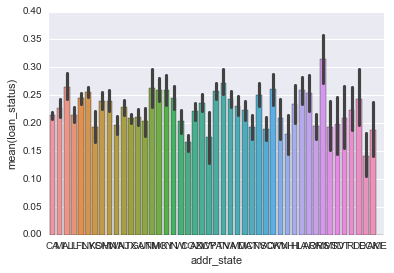

In [66]:
sns.barplot(x='addr_state', y='loan_status', data=Loan_data)

In [67]:
# divide all states into 5 regions: West, Midwest,Northeast, Southeast, Southwest
def divide(addr_state):
    if addr_state in ['ME', 'MA', 'RI', 'CT', 'NH', 'VT', 'NY', 'PA', 'NJ', 'DE', 'MD']:
        return 'Northeast'
    elif addr_state in ['WV', 'VA', 'KY', 'TE', 'NC', 'SC', 'GA', 'AL', 'MS', 'AR', 'LA', 'FL']:
        return 'Southeast'
    elif addr_state in ['OH', 'IN', 'MI', 'IL', 'MO', 'WI', 'MN', 'IA', 'KS', 'NE', 'SD', 'ND']:
        return 'Midwest'
    elif addr_state in ['TX', 'OK', 'NM', 'AZ']:
        return 'Southwest'
    else:
        return 'West'

In [68]:
Loan_data['region'] = Loan_data['addr_state'].apply(divide)

In [69]:
Loan_data.region.value_counts()

West         28291
Southeast    23036
Northeast    23001
Midwest      17736
Southwest    12448
Name: region, dtype: int64

In [70]:
Loan_data.columns.values

array(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'acc_now_delinq', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'train_flag', 'region'], dtype=object)

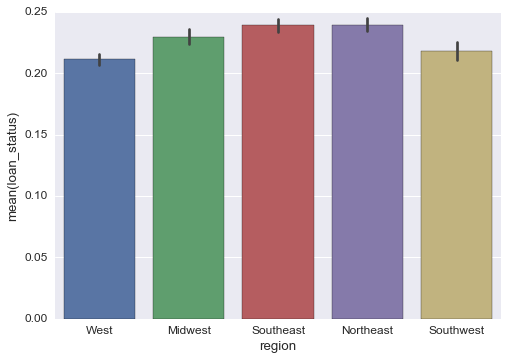

In [106]:
sns.barplot(x='region', y='loan_status', data=Loan_data)

### verification_status

In [107]:
Loan_data.verification_status.value_counts()

Source Verified    42102
Not Verified       31977
Verified           30433
Name: verification_status, dtype: int64

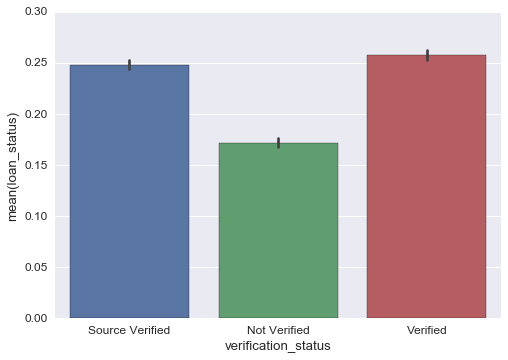

In [108]:
sns.barplot(x='verification_status', y='loan_status', data=Loan_data)

### delinq_2yrs

In [109]:
Loan_data.delinq_2yrs.describe()

count    104512.000000
mean          0.330594
std           0.882613
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.000000
Name: delinq_2yrs, dtype: float64

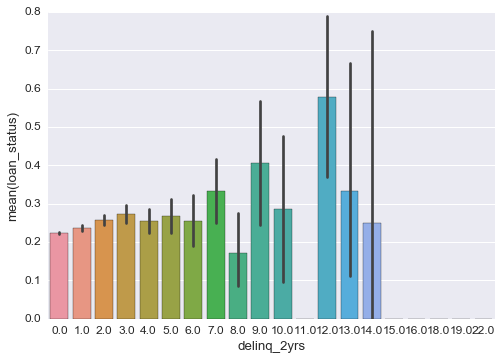

In [110]:
sns.barplot(x='delinq_2yrs', y='loan_status', data=Loan_data)

### earliest_cr_line

In [111]:
Loan_data.earliest_cr_line.describe()

count    104512.000000
mean         18.121527
std           7.204372
min           5.000000
25%          13.000000
50%          17.000000
75%          22.000000
max          72.000000
Name: earliest_cr_line, dtype: float64

(array([  1.57320000e+04,   4.77170000e+04,   2.56170000e+04,
          9.74800000e+03,   4.08800000e+03,   1.21600000e+03,
          3.14000000e+02,   6.90000000e+01,   8.00000000e+00,
          3.00000000e+00]),
 array([  5. ,  11.7,  18.4,  25.1,  31.8,  38.5,  45.2,  51.9,  58.6,
         65.3,  72. ]),
 <a list of 10 Patch objects>)

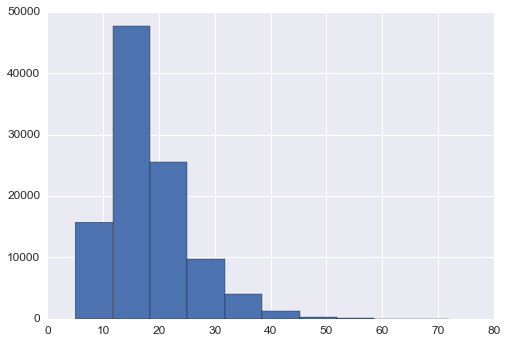

In [112]:
plt.hist(Loan_data.earliest_cr_line)

In [113]:
Loan_data.earliest_cr_line.unique()

array([30, 16, 33, 20,  9, 19, 14, 13, 15, 10, 18,  8, 25, 17, 21, 39, 12,
       34, 29, 31,  6,  5, 11, 23, 37, 40, 22, 24, 26,  7, 32, 27, 28, 35,
       47, 43, 45, 41, 38, 36, 42, 46, 44, 49, 52, 51, 54, 50, 48, 62, 57,
       58, 55, 53, 60, 59, 72, 66, 68, 56, 61])

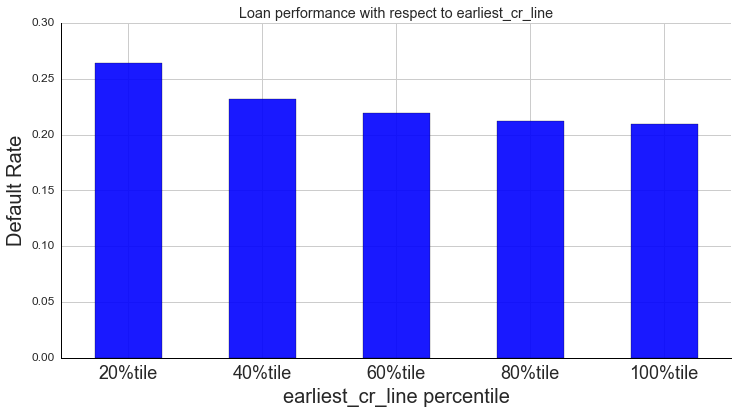

In [114]:
continuous_var_plot('earliest_cr_line')

### inq_last_6mths

In [115]:
Loan_data.inq_last_6mths.describe()

count    104512.000000
mean          0.855175
std           1.097508
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: inq_last_6mths, dtype: float64

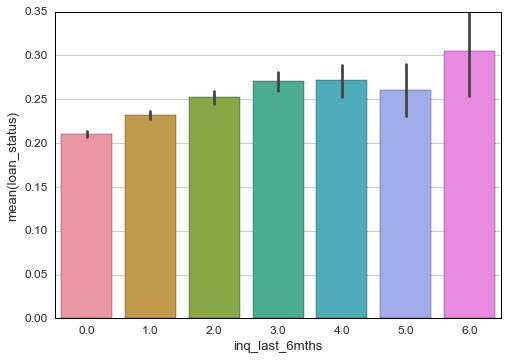

In [116]:
sns.barplot(x='inq_last_6mths', y='loan_status', data=Loan_data)

### open_acc

In [117]:
Loan_data.open_acc.describe()

count    104512.000000
mean         11.629239
std           5.212755
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          76.000000
Name: open_acc, dtype: float64

In [118]:
Loan_data.open_acc.unique()

array([ 11.,  19.,  25.,   8.,  10.,  33.,  15.,  13.,  23.,  12.,  20.,
        14.,   9.,  26.,  17.,  28.,  30.,  18.,  21.,   6.,   7.,   3.,
         5.,  16.,  24.,  27.,   4.,  22.,  29.,  38.,  31.,  45.,   2.,
        36.,  32.,  39.,  37.,  47.,  34.,  35.,   1.,  41.,  44.,  42.,
        54.,  40.,  49.,  46.,  43.,  76.,  48.,   0.,  51.,  58.,  52.,
        55.])

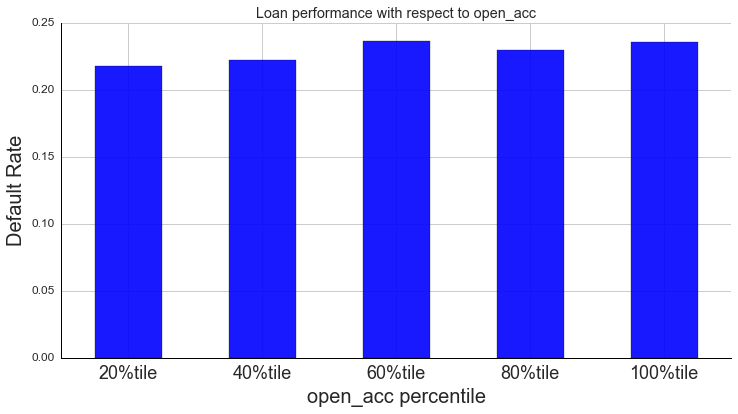

In [119]:
continuous_var_plot('open_acc')

### pub_rec

In [120]:
Loan_data.pub_rec.describe()

count    104512.000000
mean          0.232643
std           0.563754
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: pub_rec, dtype: float64

In [121]:
Loan_data.pub_rec.unique()

array([  1.,   0.,   2.,   3.,   4.,   5.,   6.,  10.,   7.,  11.,   8.,
         9.,  13.])

In [122]:
Loan_data.pub_rec.value_counts()

0.0     84595
1.0     17062
2.0      1973
3.0       546
4.0       172
5.0        90
6.0        40
7.0        14
10.0        7
8.0         5
9.0         4
11.0        3
13.0        1
Name: pub_rec, dtype: int64

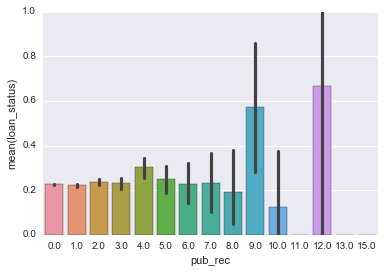

In [28]:
sns.barplot(x='pub_rec', y='loan_status', data=Loan_data)

### revol_bal

In [124]:
Loan_data.revol_bal.describe()

count    1.045120e+05
mean     1.546934e+04
std      2.003645e+04
min      0.000000e+00
25%      5.826000e+03
50%      1.077800e+04
75%      1.914100e+04
max      1.190046e+06
Name: revol_bal, dtype: float64

(array([  1.03973000e+05,   4.19000000e+02,   8.90000000e+01,
          1.80000000e+01,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([       0. ,   119004.6,   238009.2,   357013.8,   476018.4,
          595023. ,   714027.6,   833032.2,   952036.8,  1071041.4,
         1190046. ]),
 <a list of 10 Patch objects>)

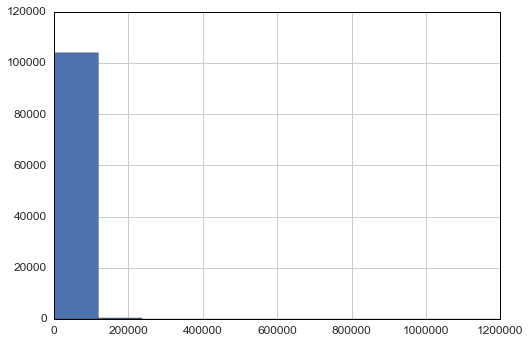

In [125]:
plt.hist(Loan_data.revol_bal)

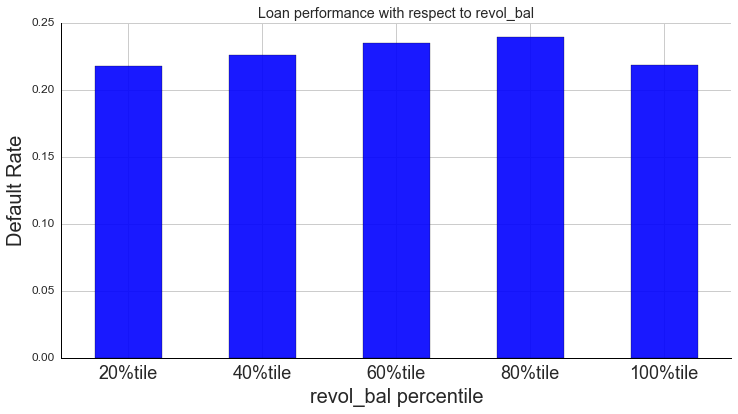

In [126]:
continuous_var_plot('revol_bal')

### revol_util

In [127]:
Loan_data.revol_util.describe()

count    104512.000000
mean         53.746058
std          23.601955
min           0.000000
25%          36.500000
50%          54.100000
75%          71.700000
max         892.300000
Name: revol_util, dtype: float64

(array([  9.74580000e+04,   7.05200000e+03,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   0.  ,   89.23,  178.46,  267.69,  356.92,  446.15,  535.38,
         624.61,  713.84,  803.07,  892.3 ]),
 <a list of 10 Patch objects>)

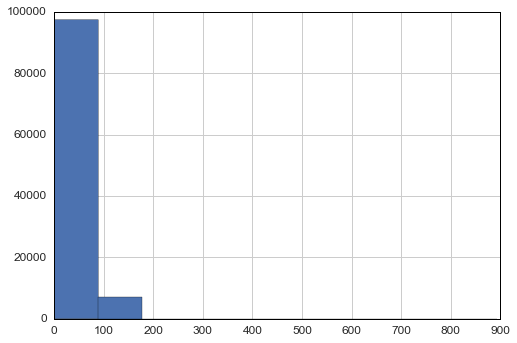

In [128]:
plt.hist(Loan_data.revol_util)

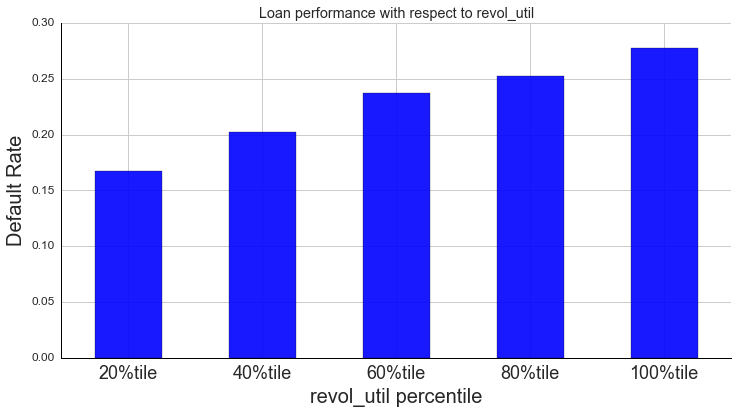

In [129]:
continuous_var_plot('revol_util')

### total_acc

In [130]:
Loan_data.total_acc.describe()

count    104512.000000
mean         26.609901
std          12.073265
min           2.000000
25%          18.000000
50%          25.000000
75%          34.000000
max         150.000000
Name: total_acc, dtype: float64

In [131]:
Loan_data.total_acc.unique()

array([  58.,   22.,   35.,   78.,   21.,   15.,   64.,   23.,   27.,
         49.,   18.,   20.,   24.,   11.,   25.,   26.,   46.,   41.,
         29.,   43.,   33.,   30.,   40.,   38.,   34.,   28.,   36.,
         60.,   16.,   12.,   19.,   14.,   31.,   10.,   17.,   42.,
         55.,    8.,   32.,   48.,   37.,   45.,   44.,   13.,   51.,
         65.,    9.,    7.,    5.,    4.,   59.,   39.,   52.,   54.,
         47.,   80.,   74.,   57.,   71.,   50.,   53.,   76.,   62.,
         63.,   61.,   75.,   56.,    6.,   67.,   68.,   73.,   84.,
         66.,   83.,   70.,   85.,   69.,   81.,   90.,   92.,   86.,
         77.,   72.,  102.,  117.,   89.,  116.,   87.,  118.,    3.,
         94.,   79.,   88.,   91.,   99.,    2.,   82.,   93.,  150.,
         95.,   98.,   97.,  119.,  100.])

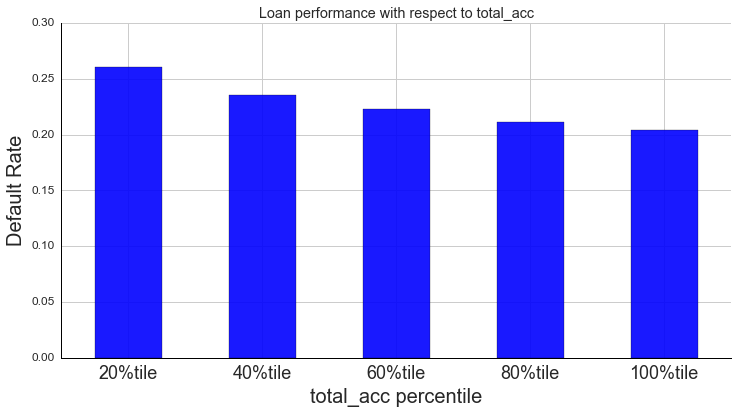

In [132]:
continuous_var_plot('total_acc')

### initial_list_status

In [133]:
Loan_data.initial_list_status.describe()

count     104512
unique         2
top            w
freq       53028
Name: initial_list_status, dtype: object

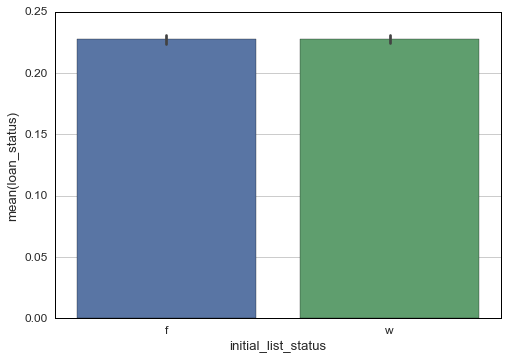

In [134]:
sns.barplot(x='initial_list_status', y='loan_status',data=Loan_data)

#### Addr_state -frequency encoding

In [135]:
# def divide(addr_state):
#     if addr_state in ['ME', 'MA', 'RI', 'CT', 'NH', 'VT', 'NY', 'PA', 'NJ', 'DE', 'MD']:
#         return 'Northeast'
#     elif addr_state in ['WV', 'VA', 'KY', 'TE', 'NC', 'SC', 'GA', 'AL', 'MS', 'AR', 'LA', 'FL']:
#         return 'Southeast'
#     elif addr_state in ['OH', 'IN', 'MI', 'IL', 'MO', 'WI', 'MN', 'IA', 'KS', 'NE', 'SD', 'ND']:
#         return 'Midwest'
#     elif addr_state in ['TX', 'OK', 'NM', 'AZ']:
#         return 'Southwest'
#     else:
#         return 'West'

In [162]:
# addr_state_freq = Loan_data.groupby("addr_state").size().reset_index()
# addr_state_freq.columns = ["addr_state", "addr_state_freq"]
# Loan_data = pd.merge(Loan_data , addr_state_freq, how = "left", on = 'addr_state')
Loan_data.drop('addr_state', axis=1, inplace=True)

#### Employment title -frequency encoding

In [137]:
# emp_title_freq = Loan_data.groupby("emp_title").size().reset_index()
# emp_title_freq.columns = ["emp_title", "emp_title_freq"]
# Loan_data = pd.merge(Loan_data , emp_title_freq, how = "left", on = 'emp_title')
# Loan_data.drop('emp_title', axis=1, inplace=True)

#### term encoding

In [159]:
Loan_data["term"] = Loan_data.term.apply(lambda x: x.split()[0])

In [160]:
Loan_data.term.value_counts()

36    76869
60    27643
Name: term, dtype: int64

In [161]:
Loan_data['term']=Loan_data['term'].astype(int)

#### purpose encoding- frequency encoding

In [74]:
# purpose_freq = Loan_data.groupby("purpose").size().reset_index()
# purpose_freq.columns = ["purpose", "purpose_freq"]
# Loan_data = pd.merge(Loan_data , purpose_freq, how = "left", on = 'purpose')
# Loan_data.drop('purpose', axis=1, inplace=True)

In [363]:
Loan_data.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
addr_state                    0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
acc_now_delinq                0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
delinq_amnt                   0
mort_acc                      0
mths_since_recent_bc          0
mths_since_recent_inq         0
num_actv_bc_tl                0
num_actv_rev_tl               0
num_bc_s

### standarize feature

In [132]:
Loan_data.loan_amnt = Loan_data.loan_amnt /Loan_data.loan_amnt.std()

In [133]:
Loan_data.annual_inc = Loan_data.annual_inc /Loan_data.annual_inc.std()

In [134]:
Loan_data.revol_bal = Loan_data.revol_bal /Loan_data.revol_bal.std()

In [135]:
Loan_data.tot_cur_bal = Loan_data.tot_cur_bal /Loan_data.tot_cur_bal.std()

In [136]:
Loan_data.total_rev_hi_lim = Loan_data.total_rev_hi_lim /Loan_data.total_rev_hi_lim.std()

In [137]:
Loan_data.avg_cur_bal = Loan_data.avg_cur_bal /Loan_data.avg_cur_bal.std()

In [138]:
Loan_data.bc_open_to_buy = Loan_data.bc_open_to_buy /Loan_data.bc_open_to_buy.std()

In [139]:
Loan_data.tot_hi_cred_lim = Loan_data.tot_hi_cred_lim /Loan_data.tot_hi_cred_lim.std()

In [140]:
Loan_data.total_bal_ex_mort = Loan_data.total_bal_ex_mort /Loan_data.total_bal_ex_mort.std()

In [141]:
Loan_data.total_bc_limit = Loan_data.total_bc_limit /Loan_data.total_bc_limit.std()

In [142]:
Loan_data.total_il_high_credit_limit = Loan_data.total_il_high_credit_limit /Loan_data.total_il_high_credit_limit.std()

In [175]:
#Loan_data.addr_state_freq = Loan_data.addr_state_freq /Loan_data.addr_state_freq.std()

In [82]:
Loan_data.columns.values

array(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'acc_now_delinq', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'delinq_amnt', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'], dtype=object)

In [178]:
# Loan_data.to_csv('X_train_ohe.csv')

#### One-hot-encoding, change the var to dummy variable

In [332]:
Loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191793 entries, 1 to 656724
Data columns (total 48 columns):
loan_amnt                     191793 non-null float64
term                          191793 non-null object
int_rate                      191793 non-null float64
grade                         191793 non-null object
sub_grade                     191793 non-null object
emp_length                    191793 non-null int64
home_ownership                191793 non-null object
annual_inc                    191793 non-null float64
verification_status           191793 non-null object
loan_status                   191793 non-null int64
purpose                       191793 non-null object
addr_state                    191793 non-null object
delinq_2yrs                   191793 non-null float64
earliest_cr_line              191793 non-null int64
inq_last_6mths                191793 non-null float64
open_acc                      191793 non-null float64
pub_rec                       191793 n

In [333]:
Y = Loan_data['loan_status']
Loan_data.drop('loan_status', axis=1,inplace=True)

In [334]:
train_size = 150000

In [335]:
y_train = Y[:train_size]
y_test = Y[train_size:]

In [336]:
print y_train.shape, y_test.shape

(150000,) (41793,)


In [337]:
#Loan_data.drop('emp_title_freq', axis=1,inplace=True)

In [338]:
# Loan_data.drop('addr_state', axis=1, inplace=True)

In [339]:
Loan_data.shape

(191793, 47)

In [340]:
#full_ohe = Loan_data.drop('loan_status', axis=1,inplace=True)
full_ohe=pd.get_dummies(Loan_data,sparse=True)
#full_ohe=sparse.csr_matrix(full_ohe)

In [341]:
full_ohe.shape

(191793, 154)

In [342]:
X_train_ohe =full_ohe[:train_size]
X_test_ohe =full_ohe[train_size:]

In [343]:
print X_train_ohe.shape, X_test_ohe.shape

(150000, 154) (41793, 154)


In [344]:
# Y = Loan_data['loan_status'][:train_size]

## Create model
### LogisticRegression

In [345]:
%%time
LR = LogisticRegression()
LR.fit(X_train_ohe,y_train)

y_pred_lr = LR.predict_proba(X_test_ohe)
print ("Score for LogisticRegression using Label Encoding is %f" % (metrics.log_loss(y_test,y_pred_lr)))

Score for LogisticRegression using Label Encoding is 0.542118
CPU times: user 31.6 s, sys: 350 ms, total: 31.9 s
Wall time: 32 s


In [346]:
type(y_pred_lr)

numpy.ndarray

In [347]:
from ggplot import *

In [348]:
y_pred = LR.predict_proba(X_test_ohe)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

In [349]:
metrics.auc(fpr, tpr)

0.6420706990908166

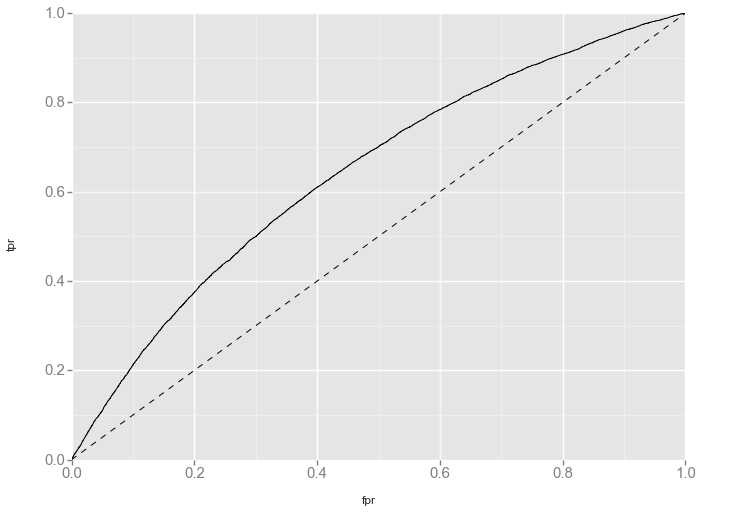

<ggplot: (320293153)>

In [350]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) + geom_line() + geom_abline(linetype='dashed')

### logistic regression with lasso (L1 penalty) 

In [351]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

In [352]:
for i, C in enumerate((100,10,3,1,0.3,0.1,0.03, 0.01)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
#     clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train_ohe,y_train)
#     clf_l2_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
#     coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm
    y_pred_lr = clf_l1_LR.predict_proba(X_test_ohe)
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
#     sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.2f" % C)
#     print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train_ohe,y_train))
    print ("Score for LogisticRegression using Label Encoding is %f" % (metrics.log_loss(y_test,y_pred_lr)))
#     print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
#     print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train_ohe,y_train))


C=100.00
score with L1 penalty: 0.7828
Score for LogisticRegression using Label Encoding is 0.505727
C=10.00
score with L1 penalty: 0.7834
Score for LogisticRegression using Label Encoding is 0.505703
C=3.00
score with L1 penalty: 0.7832
Score for LogisticRegression using Label Encoding is 0.505828
C=1.00
score with L1 penalty: 0.7834
Score for LogisticRegression using Label Encoding is 0.505838
C=0.30
score with L1 penalty: 0.7830
Score for LogisticRegression using Label Encoding is 0.506477
C=0.10
score with L1 penalty: 0.7832
Score for LogisticRegression using Label Encoding is 0.505695
C=0.03
score with L1 penalty: 0.7833
Score for LogisticRegression using Label Encoding is 0.506251
C=0.01
score with L1 penalty: 0.7829
Score for LogisticRegression using Label Encoding is 0.507769


In [354]:
# choose C = 100
clf_l1_LR = LogisticRegression(C=0.3, penalty='l1', tol=0.01)

clf_l1_LR.fit(X_train_ohe,y_train)

# coef_l1_LR contains zeros due to the
# L1 sparsity inducing norm
y_pred_lr = clf_l1_LR.predict_proba(X_test_ohe)
# sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100

print("C=%.2f" % C)
print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train_ohe,y_train))
print ("Score for LogisticRegression using Label Encoding is %f" % (metrics.log_loss(y_test,y_pred_lr)))
#     print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
y_pred = clf_l1_LR.predict_proba(X_test_ohe)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
print metrics.auc(fpr, tpr)

C=0.01
score with L1 penalty: 0.7834
Score for LogisticRegression using Label Encoding is 0.505695
0.716599270359


## XGBoost

In [355]:
from sklearn.grid_search import GridSearchCV

In [356]:
dtrain = xgb.DMatrix(X_train_ohe,y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_test_ohe,y_test, missing = np.NAN)

In [357]:
params = {"objective": "binary:logistic",
          "booster": "gbtree",
          "eta": 0.1,
          "max_depth": 6,
          "subsample_bytree": 0.6,
          "silent": 1,
          "seed": 123,
          "eval_metric": "auc",
          "min_child_weight": 3}

In [358]:
# optimized_GBM.fit(X_train_ohe, y_train)

In [359]:
# GridSearchCV(cv=5, error_score='raise',
#        estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
#        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
#        min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
#        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
#        fit_params={}, iid=True, n_jobs=-1,
#        param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
#        pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [360]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-auc:0.703579	eval-auc:0.696552
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.709642	eval-auc:0.70208
[2]	train-auc:0.711635	eval-auc:0.703378
[3]	train-auc:0.712725	eval-auc:0.70425
[4]	train-auc:0.714582	eval-auc:0.705477
[5]	train-auc:0.715713	eval-auc:0.706386
[6]	train-auc:0.716854	eval-auc:0.706932
[7]	train-auc:0.717626	eval-auc:0.707236
[8]	train-auc:0.718279	eval-auc:0.707753
[9]	train-auc:0.719013	eval-auc:0.708024
[10]	train-auc:0.719876	eval-auc:0.708591
[11]	train-auc:0.720636	eval-auc:0.708936
[12]	train-auc:0.721437	eval-auc:0.709522
[13]	train-auc:0.722367	eval-auc:0.709872
[14]	train-auc:0.723224	eval-auc:0.710309
[15]	train-auc:0.7238	eval-auc:0.71056
[16]	train-auc:0.724501	eval-auc:0.710859
[17]	train-auc:0.725097	eval-auc:0.711277
[18]	train-auc:0.725815	eval-auc:0.711636
[19]	train-auc:0.726665	eval-auc:0.712027
[20]	train-auc:0.7273	eval-auc:0.7

Area under the ROC curve - train: 0.725505 
Area under the ROC curve - test: 0.799572 


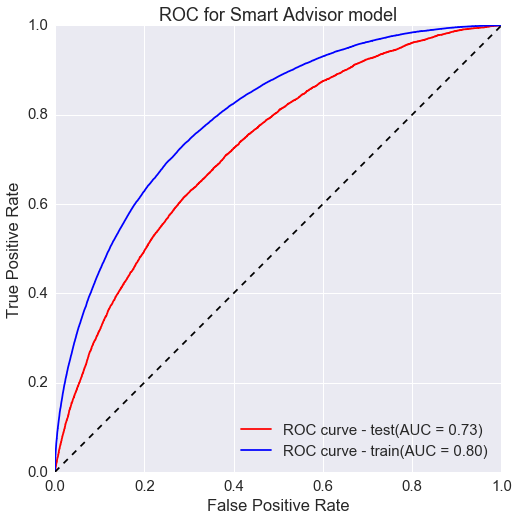

In [361]:
probs = gbm.predict(dvalid, ntree_limit=gbm.best_ntree_limit)
probs_1 = gbm.predict(dtrain, ntree_limit=gbm.best_ntree_limit)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_train, probs_1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc_1 = metrics.auc(fpr_1, tpr_1)
print "Area under the ROC curve - train: %f " % roc_auc
print "Area under the ROC curve - test: %f " % roc_auc_1
# plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr,tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
plt.plot(fpr_1,tpr_1, label='ROC curve - train(AUC = %0.2f)' % roc_auc_1, color='b')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC for Smart Advisor model")
plt.legend(loc="lower right")
plt.show()
sns.despine()


In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

In [81]:
thresholds

array([ 1.89658034,  0.89658034,  0.7895776 , ...,  0.01757259,
        0.0175711 ,  0.00630215], dtype=float32)

In [82]:
probs

array([ 0.07856458,  0.59687483,  0.11189198, ...,  0.44748196,
        0.17155536,  0.50595152], dtype=float32)

In [83]:
def binary(x):
    if x > 0.7: 
        return 1
    else:
        return 0

In [84]:
probs_bi = map(binary, probs)

### Distribution of predicted values

In [85]:
y_pred = gbm.predict(dvalid)

In [86]:
print "Accuracy : %.4g" % metrics.accuracy_score(y_test, probs_bi)

Accuracy : 0.7537


In [209]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.904573 0.00417183 0.220872


### Feature importance

In [210]:
from xgboost import plot_importance

In [362]:
gbm = xgb.train(params, dtrain, 64)

In [363]:
sns.set(font_scale = 1.5)

In [364]:
importances = gbm.get_fscore()

In [365]:
importance_frame.sort_values?

In [366]:
importance_frame[-10:]

,Feature,Importance
19,mths_since_recent_bc,411
49,revol_util,413
52,total_bc_limit,423
90,bc_util,439
137,bc_open_to_buy,443
112,int_rate,497
109,revol_bal,514
20,avg_cur_bal,515
77,loan_amnt,674
83,annual_inc,789


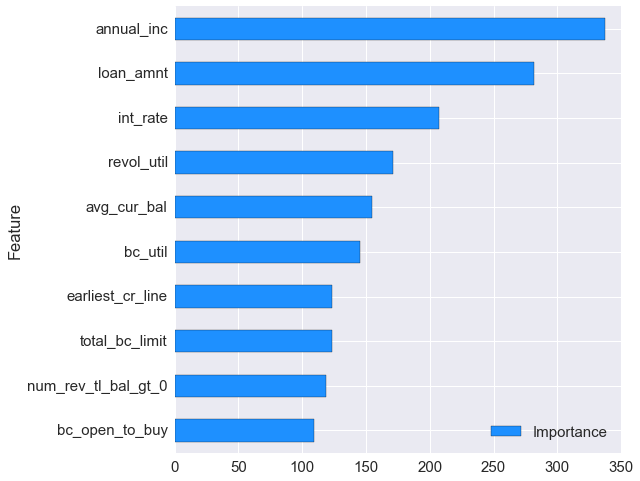

In [367]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending=True)
importance_frame[-10:].plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'dodgerblue')

# tune the parameters

In [ ]:
# use a method from website

In [160]:
def modelfit(alg, X_train_ohe, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train_ohe, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train_ohe, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train_ohe)
    dtrain_predprob = alg.predict_proba(X_train_ohe)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [159]:
xgb.cv?

In [157]:
from xgboost.sklearn import XGBClassifier


Model Report
Accuracy : 0.8
AUC Score (Train): 0.780762


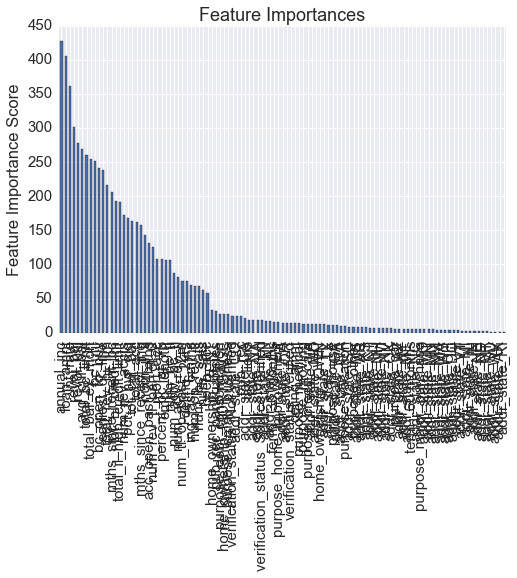

In [161]:
#Choose all predictors except target & IDcols
# predictors = X_train_ohe
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train_ohe, y_train)

In [398]:
import sys
import math
from sklearn.grid_search import GridSearchCV
sys.path.append('xgboost/wrapper/')
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
    
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
        
    def predict(self, X):
        num2label = dict((i, label) for label, i in self.label2num.items())
        Y =self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
    
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
    
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self

In [399]:
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true))/len(Y_pred)

In [400]:
clf = XGBoostClassifier(
        eval_metric = 'auc',
        num_class = 2,
        nthread = 4,
        eta = 0.1,
        num_boost_round = 80,
        max_depth = 12,
        subsample = 0.5,
        colsample_bytree = 1.0,
        silent = 1,
        )
para = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0]
}
clf = GridSearchCV(clf, para, n_jobs=1, cv=2)

In [401]:
%%time
clf.fit(X_train_ohe, y_train)

CPU times: user 7h 23min 56s, sys: 14min 26s, total: 7h 38min 23s
Wall time: 2h 23min 5s


GridSearchCV(cv=2, error_score='raise',
       estimator=<__main__.XGBoostClassifier instance at 0x120e532d8>,
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.9, 1.0], 'num_boost_round': [100, 250, 500], 'eta': [0.05, 0.1, 0.3], 'colsample_bytree': [0.9, 1.0], 'max_depth': [6, 9, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [407]:
clf.score(X_train_ohe, y_train)

2.2086297749296677

In [408]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print(score)
for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))

2.06046883872
colsample_bytree: 0.9
eta: 0.05
max_depth: 6
num_boost_round: 100
subsample: 0.9


## Data visulization

In [215]:
import plotly.plotly as py
py.sign_in('jackbowenzhi', 'zrDWOXMUh7DZ22tFTgRm')

In [216]:
table = Loan_data[:]

In [217]:
table.shape

(191793, 48)

In [218]:
type(table)

pandas.core.frame.DataFrame

In [221]:
Y.shape

(191793,)

In [222]:
table['Loan_status'] = Y

/Users/bowenzhi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [223]:
# table['y_pred'] = y_pred

In [ ]:
X_test_ohe,y_test, y_pred

In [224]:
table.shape

(191793, 49)

In [225]:
table.addr_state.isnull().sum()

0

In [226]:
table.addr_state.shape

(191793,)

In [227]:
table.addr_state.unique().shape

(49,)

In [228]:
# df.addr_state.replace(np.nan, 'CA', inplace=True)

In [229]:
table.addr_state.unique().shape

(49,)

In [230]:
# df = df[df.addr_state !='DC']

In [231]:
table_1 = table.groupby('addr_state').agg({'Loan_status': np.mean})

In [232]:
table_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, AK to WY
Data columns (total 1 columns):
Loan_status    49 non-null float64
dtypes: float64(1)
memory usage: 784.0+ bytes


In [233]:
table_1

,Loan_status
addr_state,
AK,0.209877
AL,0.268070
AR,0.254301
AZ,0.217893
CA,0.213905
CO,0.162864
CT,0.207383
DC,0.151277
DE,0.230769


In [234]:
table_1.reset_index(level=0, inplace=True)

In [235]:
table_1

,addr_state,Loan_status
0,AK,0.209877
1,AL,0.268070
2,AR,0.254301
3,AZ,0.217893
4,CA,0.213905
5,CO,0.162864
6,CT,0.207383
7,DC,0.151277
8,DE,0.230769
9,FL,0.241830


In [236]:
import plotly.plotly as py


In [237]:
df = table_1

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['addr_state'] 
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['addr_state'],
        z = df['Loan_status'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Millions USD"
        )
    ) ]

layout = dict(
        title = '2014-15 US real Default Rate by State (@LendingClub)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)

url = py.plot(fig, filename='d3-cloropleth-map')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jackbowenzhi/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [238]:
# group by grade

In [240]:
table_B = table[table.grade=='B']

In [241]:
table_B.shape

(48289, 49)

In [369]:
table_B['Loan_status'].mean()

0.13632504297044876

In [242]:
table_B_1 = table_B.groupby('addr_state').agg({'Loan_status': np.mean})

In [243]:
table_B_1.reset_index(level=0, inplace=True)

In [244]:
table_B_1

,addr_state,Loan_status
0,AK,0.105263
1,AL,0.147314
2,AR,0.207831
3,AZ,0.124398
4,CA,0.129682
5,CO,0.104305
6,CT,0.135783
7,DC,0.078740
8,DE,0.166667
9,FL,0.148583


In [246]:
df = table_B_1

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['addr_state'] 
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['addr_state'],
        z = df['Loan_status'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Millions USD"
        )
    ) ]

layout = dict(
        title = '2014-15 US Default Rate of Grade B by State (@LendingClub)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)

url = py.plot(fig, filename='d3-cloropleth-map')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jackbowenzhi/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [247]:
# grade F

In [248]:
table_F = table[table.grade=='F']
table_F_1 = table_F.groupby('addr_state').agg({'Loan_status': np.mean})

In [250]:
table_F_1.reset_index(level=0, inplace=True)

In [370]:
table_F['Loan_status'].mean()

0.453693749040086

In [252]:
df = table_F_1

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['addr_state'] 
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['addr_state'],
        z = df['Loan_status'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Millions USD"
        )
    ) ]

layout = dict(
        title = '2014-15 US Default Rate of Grade F by State (@LendingClub)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)

url = py.plot(fig, filename='d3-cloropleth-map')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jackbowenzhi/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [253]:
# grade D

In [254]:
table_D = table[table.grade=='D']
table_D_1 = table_D.groupby('addr_state').agg({'Loan_status': np.mean})

In [255]:
table_D_1.reset_index(level=0, inplace=True)

In [371]:
table_D['Loan_status'].mean()

0.31957865413075653

In [256]:
df = table_D_1

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['addr_state'] 
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['addr_state'],
        z = df['Loan_status'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Millions USD"
        )
    ) ]

layout = dict(
        title = '2014-15 US Default Rate of Grade D by State (@LendingClub)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)

url = py.plot(fig, filename='d3-cloropleth-map')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jackbowenzhi/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'
